## Download data & packages

In [1]:
import pandas as pd
from nltk.stem import PorterStemmer
from gensim.models.word2vec import Word2Vec
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.layers import Embedding, GRU, LSTM, Dropout, SpatialDropout1D
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import TomekLinks 

In [2]:
!gdown '1a7gqhHhuwa4PQKBwD7kdiA0XZVKBRYHx'
!gdown '1D9b7ik8y9fccX-gVsoPawOfBUKBX_-GZ'
!gdown '1ZhP9UUWSg5spmrGUdd1yIdpKytWmETNa'
!gdown '1WFLvfTIFcXvq__1saG_guv6Z6c2yjWf8'
!gdown '14Yc3iHSFnY4k0G0QAikSSIRevJPx08Ke'
!gdown '1hY32lCbt435R0qda_GoNOVFHRfSzn3Jx'
!gdown '1_DJlkcJUtZkpomafImkakpJzC4PTuu-C'
!gdown '17H6oMAEtrkxlOZteEoyYJu6PGa_R_Fn7'

Downloading...
From: https://drive.google.com/uc?id=1a7gqhHhuwa4PQKBwD7kdiA0XZVKBRYHx
To: /content/users.csv
100% 2.69M/2.69M [00:00<00:00, 57.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1D9b7ik8y9fccX-gVsoPawOfBUKBX_-GZ
To: /content/users_ask.csv
100% 1.10M/1.10M [00:00<00:00, 88.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ZhP9UUWSg5spmrGUdd1yIdpKytWmETNa
To: /content/users_ans.csv
100% 1.86M/1.86M [00:00<00:00, 85.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WFLvfTIFcXvq__1saG_guv6Z6c2yjWf8
To: /content/top_tags.csv
100% 5.64M/5.64M [00:00<00:00, 40.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=14Yc3iHSFnY4k0G0QAikSSIRevJPx08Ke
To: /content/questions.csv
100% 104M/104M [00:06<00:00, 15.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hY32lCbt435R0qda_GoNOVFHRfSzn3Jx
To: /content/answerer.csv
100% 27.7M/27.7M [00:00<00:00, 69.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_DJlkcJUtZkpomafImkakpJzC4PTuu-

In [53]:
answer = pd.read_csv('answer.csv')
answerer = pd.read_csv('answerer.csv', encoding='latin1')
question = pd.read_csv('questions.csv', sep='\t')
user = pd.read_csv('users.csv')
userAns = pd.read_csv('users_ans.csv')
userAsk = pd.read_csv('users_ask.csv')

## Preprocess: prepare dataset

In [54]:
answer = answer.merge(answerer, left_on=['answerer_id','answer_id'], right_on = ['user_id','answer_id'])
answer = answer.merge(question, left_on='question_id', right_on='question_id')

In [55]:
answer = answer.merge(userAns, left_on=['answerer_id'], right_on = ['user_id'])
answer = answer.merge(userAsk, left_on=['asker_id'], right_on = ['user_id'])

In [56]:
# question tags 不知道怎麼用, 可能之後分類預測？？？
data = answer.drop(['answer_creation_date', 
                  'answer_link', 
                  'answer_id', 
                  # 'question_id', 
                  'answer_last_activity_date', 
                  'answer_last_edit_date', 
                  'answerer_id', 
                  'question_creation_date', 
                  'question_last_activity_date', 
                  'question_last_edit_date', 
                  'asker_id', 
                  'question_body_original', 
                  'answer_original', 
                  'profile_image', 
                  'display_name', 
                  'link', 
                  'user_id', 
                  'answer_external_link', 
                  'question_tags_x', 
                  'answerer_tags', 
                  'common_tag', 
                  'user_id_x', 
                  'question_tags_y', 
                  'user_id_y'], axis=1)

In [7]:
# 純文字變數
wordCol = ['answer_body', 'question_title', 'question_body']
# 純文字＆回答內容變數
wordAnsCol = [ 'answer_score', 'answer_code_size', 'answer_age', 
              'answer_score_sum', 'number_of_answer', 'answer_score_ratio', 
              'answer_position', 'answer_relative_position', 'answer_size', 
              'answer_GF', 'answer_FK', 'common', 'answer_upper_count', 
              'answer_upper', 'answer_polarity', 'answer_subjectivity', 
              'cosine_similarity', 'question_code_size']
# 純文字＆回答者變數
wordAnswerCol =['answerer_reputation', 'answerer_accept_rate', 'reputation', 
                'accept_rate', 'all_badge_x', 'gold_badge_x', 
                'silver_badge_x', 'bronze_badge_x', 'vote_x', 'answer_count_x', 
                'question_count_x', 'reputation_change_year_x', 'all_badge_y', 
                'gold_badge_y', 'silver_badge_y', 'bronze_badge_y', 'vote_y', 
                'answer_count_y', 'question_count_y', 'reputation_change_year_y'
                , 0, 1]
# 純文字＆回答內容變數＆回答內容變數
wordAnswerAnsCol = ['answer_score', 'answer_code_size', 'answerer_reputation', 
                    'answerer_accept_rate', 'answer_age', 'answer_score_sum', 
                    'number_of_answer', 'answer_score_ratio', 
                    'answer_position', 'answer_relative_position', 
                    'answer_size', 'answer_GF', 'answer_FK', 'common', 
                    'answer_upper_count', 'answer_upper', 'answer_polarity', 
                    'answer_subjectivity', 'cosine_similarity', 'reputation', 
                    'accept_rate', 'question_code_size', 
                    'all_badge_x', 'gold_badge_x', 'silver_badge_x', 
                    'bronze_badge_x', 'vote_x', 'answer_count_x', 
                    'question_count_x', 'reputation_change_year_x', 
                    'all_badge_y', 'gold_badge_y', 'silver_badge_y', 
                    'bronze_badge_y', 'vote_y', 'answer_count_y', 
                    'question_count_y', 'reputation_change_year_y', 0, 1]

處理數值變數：\
1.處理inf\
2.以平均數補補na\
3.標準化>>做了反而都猜0

In [57]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [58]:
def minmax_norm(col):
    return (col - col.min()) / ( col.max() - col.min())

In [59]:
numCol = list(data.loc[:, ~data.columns.isin(['answer_body', 'question_title', 
                                'question_body', 'is_accepted', 
                                'user_type'])].columns)
for col in numCol:
  data[col].fillna((data[col].mean()), inplace=True)
  # data[col] = minmax_norm(data[col])

## Process word data: word2vec

In [11]:
def preprocess(text):
    text = text.str.replace(',', '')
    text = text.str.replace('.', '')
    text = text.str.replace('"', '')
    text = text.str.replace(';', '')
    text = text.str.replace('(', '')
    text = text.str.replace(')', '')
    text = text.str.lower()
    text = text.str.replace('-', ' ')
    text = text.str.replace('/', ' ')
    text = text.str.replace('  ', ' ')
    num = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0']
    for n in num:
        text = text.str.replace(n, '')
    text = text.str.split(" ")
    return text

In [12]:
def removeStop(lst):
  stemmer = PorterStemmer()
  for i in range(len(lst)):
    tmp = []
    try:
      for j in range(len(lst[i])):
        if lst[i][j] not in stopWords:
          tmp.append(stemmer.stem(lst[i][j]))
    except:
      pass
    lst[i] = tmp
  return lst

In [13]:
stopWords = ['and', 'a', 'an', 'the', 'to', 'i', 'is', 'are', '', 'was', 
             'is', 'are', 'were', 'but', 'in', 'for', 'on', 'of', 'with', 
             'from', 'there', 'it', 'they', 'we', 'he', 'she', 'them', 
             'him', 'her', 'you', 'my', 'how', 'what', 'who', 'where', 'as', 
             'be', 'so', 'your', 'yours', 'their', 'us', 'our', 'will', 
             'would', 'if', 'that', 'or', 'i\'m']

In [60]:
for col in wordCol:
  tmp = preprocess(data[col])
  data[col] = removeStop(tmp)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  import sys


In [15]:
wordLst = pd.concat([data['answer_body'], 
                     data['question_title'], 
                     data['question_body']]).sample(frac=1)
wordLst.head()

26688     [here, option, reshap, 'long', format, group, ...
141571    [some, logic, mistak, codeth, first, one, cons...
26505     [can, also, use, follow, solut, follow, solut,...
32926      [call, member, function, case, when, statement?]
30289     [extract, subset, dictionari, panda, datafram,...
dtype: object

In [16]:
model = Word2Vec(wordLst, window=5, sg=1)
model.save('demo_word2vec.model')

In [61]:
import numpy as np
try:
  embedding_matrix = np.zeros((len(model.wv.vocab.items()) + 1, model.vector_size))
  word2idx = {}

  vocab_list = [(word, model.wv[word]) for word, _ in model.wv.vocab.items()]
  for i, vocab in enumerate(vocab_list):
      word, vec = vocab
      embedding_matrix[i + 1] = vec
      word2idx[word] = i + 1
except:
  embedding_matrix = np.zeros((len(model.wv.key_to_index.items()) + 1, model.vector_size))
  word2idx = {}

  vocab_list = [(word, model.wv[word]) for word, _ in model.wv.key_to_index.items()]
  for i, vocab in enumerate(vocab_list):
      word, vec = vocab
      embedding_matrix[i + 1] = vec
      word2idx[word] = i + 1

In [62]:
def text_to_index(corpus):
    new_corpus = []
    for doc in corpus:
        new_doc = []
        try:
          for word in doc:
              try:
                  new_doc.append(word2idx[word])
              except:
                  new_doc.append(0)
        except:
          new_doc.append(0)

        new_corpus.append(new_doc)
    return np.array(new_corpus)

In [63]:
for col in wordCol:
  data[col] = text_to_index(data[col])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


In [64]:
for col in wordCol:
  data[col] = pad_sequences(data[col], maxlen=25, padding='post', value=0).tolist()

## Process number: deal with category columns

In [65]:
encoder = OneHotEncoder(handle_unknown='ignore', drop='first')

In [66]:
data['is_accepted'] = pd.DataFrame(encoder.fit_transform(data[['is_accepted']]).toarray())

In [67]:
tmp = pd.DataFrame(encoder.fit_transform(data[['user_type']]).toarray())
data = data.join(tmp)
data = data.drop(['user_type'], axis=1)

In [83]:
result = data.iloc[[3355,3356],:]

In [86]:
result = result.drop(columns='question_id')

In [87]:
result.to_csv('demo_data.csv')

In [25]:
data.columns

Index([             'is_accepted',             'answer_score',
            'answerer_reputation',     'answerer_accept_rate',
               'answer_code_size',              'answer_body',
                     'answer_age',         'answer_score_sum',
               'number_of_answer',       'answer_score_ratio',
                'answer_position', 'answer_relative_position',
                    'answer_size',                'answer_GF',
                      'answer_FK',                   'common',
             'answer_upper_count',             'answer_upper',
                'answer_polarity',      'answer_subjectivity',
              'cosine_similarity',               'reputation',
                    'accept_rate',           'question_title',
                  'question_body',       'question_code_size',
                    'all_badge_x',             'gold_badge_x',
                 'silver_badge_x',           'bronze_badge_x',
                         'vote_x',           'answer_co

## Train-test split

In [27]:
trainData, testData = train_test_split(data, test_size=0.33, random_state=21)

In [28]:
trainY = trainData['is_accepted']
testY = testData['is_accepted']
trainX = trainData.loc[:, ~trainData.columns.isin(['is_accepted'])]
testX = testData.loc[:, ~testData.columns.isin(['is_accepted'])]

## train with words only

In [ ]:
Y = np.array(trainY)

In [ ]:
tmp1 = np.array(trainX['answer_body'].tolist())
tmp2 = np.array(trainX['question_title'].tolist())
tmp3 = np.array(trainX['question_body'].tolist())
X = np.concatenate((tmp1, tmp2, tmp3), axis=1)

In [ ]:
X = X.reshape(X.shape[0], X.shape[1], 1)

In [ ]:
X.shape

(105161, 75, 1)

In [ ]:
def trainModel():
  model = Sequential()
  model.add(Conv1D(64, 2, activation="relu", input_shape=(75,1)))
  model.add(Dense(16, activation="relu"))
  model.add(MaxPooling1D())
  model.add(Flatten())
  model.add(Dense(1, activation = 'tanh'))
    
  model.compile(optimizer='adam',
                loss='squared_hinge',
                metrics=['accuracy'])
  return model

In [ ]:
trainModel = trainModel()
trainModel.fit(x=X
               , y=Y
               , batch_size=256
               , epochs=50
               , validation_split=0.3)

Epoch 1/50
288/288 [==============================] - 13s 42ms/step - loss: 1.3708 - accuracy: 0.6573 - val_loss: 1.1886 - val_accuracy: 0.7028
Epoch 2/50
288/288 [==============================] - 8s 28ms/step - loss: 1.2142 - accuracy: 0.6964 - val_loss: 1.1786 - val_accuracy: 0.7053
Epoch 3/50
288/288 [==============================] - 6s 22ms/step - loss: 1.1812 - accuracy: 0.7047 - val_loss: 1.1786 - val_accuracy: 0.7053
Epoch 4/50
288/288 [==============================] - 7s 23ms/step - loss: 1.1812 - accuracy: 0.7047 - val_loss: 1.1786 - val_accuracy: 0.7053
Epoch 5/50
288/288 [==============================] - 6s 23ms/step - loss: 1.1812 - accuracy: 0.7047 - val_loss: 1.1786 - val_accuracy: 0.7053
Epoch 6/50
288/288 [==============================] - 6s 22ms/step - loss: 1.1812 - accuracy: 0.7047 - val_loss: 1.1786 - val_accuracy: 0.7053
Epoch 7/50
288/288 [==============================] - 7s 23ms/step - loss: 1.1812 - accuracy: 0.7047 - val_loss: 1.1786 - val_accuracy: 0.705

In [41]:
test_Y = np.array(testY)

In [ ]:
tmp1 = np.array(testX['answer_body'].tolist())
tmp2 = np.array(testX['question_title'].tolist())
tmp3 = np.array(testX['question_body'].tolist())
test_X = np.concatenate((tmp1, tmp2, tmp3), axis=1)

In [ ]:
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)

In [ ]:
pred_Y = trainModel.predict(test_X)

result

In [ ]:
result = []
for i in range(len(pred_Y)):
  if pred_Y[i] < 0.5:
    result.append(0)
  else:
    result.append(1)
accuracy_score(test_Y, result)

0.70783458182099

## train with word + 回答內容相關變數

In [ ]:
tmp1 = np.array(trainX['answer_body'].tolist())
tmp2 = np.array(trainX['question_title'].tolist())
tmp3 = np.array(trainX['question_body'].tolist())
X = np.concatenate((tmp1, tmp2, tmp3), axis=1)

In [ ]:
tmp = trainX[wordAnsCol].to_numpy()
X = np.concatenate((X, tmp), axis=1)

In [ ]:
tmp1 = np.array(testX['answer_body'].tolist())
tmp2 = np.array(testX['question_title'].tolist())
tmp3 = np.array(testX['question_body'].tolist())
test_X = np.concatenate((tmp1, tmp2, tmp3), axis=1)

In [ ]:
tmp = testX[wordAnsCol].to_numpy()
test_X = np.concatenate((test_X, tmp), axis=1)

In [ ]:
X = X.reshape(X.shape[0], X.shape[1], 1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)

In [ ]:
X.shape

(105161, 93, 1)

In [ ]:
def trainModel():
  model = Sequential()
  model.add(Conv1D(64, 2, activation="relu", input_shape=(93,1)))
  model.add(Dense(16, activation="relu"))
  model.add(MaxPooling1D())
  model.add(Flatten())
  model.add(Dense(1, activation = 'sigmoid'))
    
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

In [ ]:
trainModel = trainModel()
trainModel.fit(x=X
               , y=Y
               , batch_size=128
               , epochs=100
               , validation_split=0.5)

Epoch 1/100
411/411 [==============================] - 9s 19ms/step - loss: 225.1932 - accuracy: 0.5897 - val_loss: 135.5394 - val_accuracy: 0.6018
Epoch 2/100
411/411 [==============================] - 8s 18ms/step - loss: 134.4796 - accuracy: 0.6039 - val_loss: 29.6190 - val_accuracy: 0.5577
Epoch 3/100
411/411 [==============================] - 8s 18ms/step - loss: 128.4057 - accuracy: 0.6297 - val_loss: 88.6482 - val_accuracy: 0.6439
Epoch 4/100
411/411 [==============================] - 8s 20ms/step - loss: 74.5906 - accuracy: 0.6594 - val_loss: 16.4893 - val_accuracy: 0.6195
Epoch 5/100
411/411 [==============================] - 8s 18ms/step - loss: 55.9558 - accuracy: 0.6689 - val_loss: 42.6182 - val_accuracy: 0.6949
Epoch 6/100
411/411 [==============================] - 8s 18ms/step - loss: 15.9946 - accuracy: 0.7225 - val_loss: 0.5107 - val_accuracy: 0.7569
Epoch 7/100
411/411 [==============================] - 7s 18ms/step - loss: 0.5023 - accuracy: 0.7600 - val_loss: 0.5002 

In [ ]:
pred_Y = trainModel.predict(test_X)

result

In [ ]:
result = []
for i in range(len(pred_Y)):
  if pred_Y[i] < 0.5:
    result.append(0)
  else:
    result.append(1)
accuracy_score(test_Y, result)

0.7682832651169974

## train with word + 回答者相關變數

In [ ]:
tmp1 = np.array(trainX['answer_body'].tolist())
tmp2 = np.array(trainX['question_title'].tolist())
tmp3 = np.array(trainX['question_body'].tolist())
X = np.concatenate((tmp1, tmp2, tmp3), axis=1)

In [ ]:
tmp = trainX[wordAnswerCol].to_numpy()
X = np.concatenate((X, tmp), axis=1)

In [ ]:
tmp1 = np.array(testX['answer_body'].tolist())
tmp2 = np.array(testX['question_title'].tolist())
tmp3 = np.array(testX['question_body'].tolist())
test_X = np.concatenate((tmp1, tmp2, tmp3), axis=1)

In [ ]:
tmp = testX[wordAnswerCol].to_numpy()
test_X = np.concatenate((test_X, tmp), axis=1)

In [ ]:
X = X.reshape(X.shape[0], X.shape[1], 1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)

In [ ]:
X.shape

(105161, 97, 1)

In [ ]:
def trainModel():
  model = Sequential()
  model.add(Conv1D(64, 2, activation="relu", input_shape=(97,1)))
  model.add(Dense(16, activation="relu"))
  model.add(MaxPooling1D())
  model.add(Flatten())
  model.add(Dense(1, activation = 'sigmoid'))
    
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

In [ ]:
trainModel = trainModel()
trainModel.fit(x=X
               , y=Y
               , batch_size=256
               , epochs=50
               , validation_split=0.5)

Epoch 1/50
206/206 [==============================] - 11s 48ms/step - loss: 52.8657 - accuracy: 0.5914 - val_loss: 12.3630 - val_accuracy: 0.5881
Epoch 2/50
206/206 [==============================] - 7s 33ms/step - loss: 8.6126 - accuracy: 0.5865 - val_loss: 2.6918 - val_accuracy: 0.5298
Epoch 3/50
206/206 [==============================] - 7s 33ms/step - loss: 3.6056 - accuracy: 0.5935 - val_loss: 1.6516 - val_accuracy: 0.5648
Epoch 4/50
206/206 [==============================] - 7s 32ms/step - loss: 3.8293 - accuracy: 0.6095 - val_loss: 1.2946 - val_accuracy: 0.6085
Epoch 5/50
206/206 [==============================] - 7s 32ms/step - loss: 3.6602 - accuracy: 0.6112 - val_loss: 3.5216 - val_accuracy: 0.6894
Epoch 6/50
206/206 [==============================] - 7s 32ms/step - loss: 3.1053 - accuracy: 0.6137 - val_loss: 3.2285 - val_accuracy: 0.5857
Epoch 7/50
206/206 [==============================] - 7s 33ms/step - loss: 1.9482 - accuracy: 0.6287 - val_loss: 1.5688 - val_accuracy: 0.6

In [ ]:
pred_Y = trainModel.predict(test_X)

result

In [ ]:
result = []
for i in range(len(pred_Y)):
  if pred_Y[i] < 0.5:
    result.append(0)
  else:
    result.append(1)
accuracy_score(test_Y, result)

0.7079504208819214

## train with word + 回答內容相關變數＋回答者相關變數

In [94]:
Y = np.array(trainY)

In [88]:
tmp1 = np.array(trainX['answer_body'].tolist())
tmp2 = np.array(trainX['question_title'].tolist())
tmp3 = np.array(trainX['question_body'].tolist())
X = np.concatenate((tmp1, tmp2, tmp3), axis=1)

In [89]:
tmp = trainX[wordAnswerAnsCol].to_numpy()
X = np.concatenate((X, tmp), axis=1)

In [90]:
tmp1 = np.array(testX['answer_body'].tolist())
tmp2 = np.array(testX['question_title'].tolist())
tmp3 = np.array(testX['question_body'].tolist())
test_X = np.concatenate((tmp1, tmp2, tmp3), axis=1)

In [91]:
tmp = testX[wordAnswerAnsCol].to_numpy()
test_X = np.concatenate((test_X, tmp), axis=1)

In [92]:
X = X.reshape(X.shape[0], X.shape[1], 1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)

In [93]:
X.shape

(105161, 115, 1)

In [36]:
def trainModel():
  model = Sequential()
  model.add(Conv1D(64, 2, activation="relu", input_shape=(115,1)))
  model.add(Dense(16, activation="relu"))
  model.add(MaxPooling1D())
  model.add(Flatten())
  model.add(Dense(1, activation = 'sigmoid'))
    
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

In [37]:
trainModel = trainModel()
trainModel.fit(x=X
               , y=Y
               , batch_size=256
               , epochs=80
               , validation_split=0.5)

Epoch 1/80
206/206 [==============================] - 10s 46ms/step - loss: 866.8329 - accuracy: 0.5913 - val_loss: 229.7149 - val_accuracy: 0.5783
Epoch 2/80
206/206 [==============================] - 8s 37ms/step - loss: 190.9402 - accuracy: 0.5891 - val_loss: 132.9452 - val_accuracy: 0.6767
Epoch 3/80
206/206 [==============================] - 6s 29ms/step - loss: 147.3940 - accuracy: 0.5934 - val_loss: 63.2163 - val_accuracy: 0.5591
Epoch 4/80
206/206 [==============================] - 6s 29ms/step - loss: 104.2918 - accuracy: 0.5959 - val_loss: 121.9155 - val_accuracy: 0.6443
Epoch 5/80
206/206 [==============================] - 6s 29ms/step - loss: 130.0529 - accuracy: 0.5960 - val_loss: 91.7869 - val_accuracy: 0.5711
Epoch 6/80
206/206 [==============================] - 8s 38ms/step - loss: 107.3422 - accuracy: 0.6035 - val_loss: 90.2292 - val_accuracy: 0.7043
Epoch 7/80
206/206 [==============================] - 6s 30ms/step - loss: 87.0531 - accuracy: 0.6048 - val_loss: 121.00

In [108]:
trainModel.save('demoＭodel.h5')

In [39]:
pred_Y = trainModel.predict(test_X)

result

In [42]:
result = []
for i in range(len(pred_Y)):
  if pred_Y[i] < 0.5:
    result.append(0)
  else:
    result.append(1)
accuracy_score(test_Y, result)

0.7711985481504363

In [101]:
from sklearn.metrics import roc_auc_score
roc_auc_score(test_Y, pred_Y)

0.7905679940417669

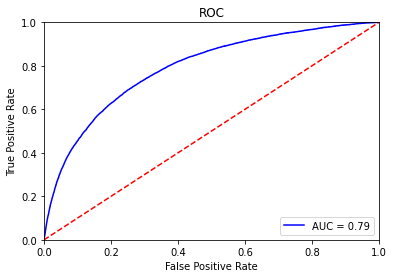

In [105]:
import matplotlib.pyplot as plt
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(test_Y, pred_Y)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Under-sampling

In [ ]:
allCol = ['answer_score', 'answer_code_size', 'answer_age', 
          'answer_score_sum', 'number_of_answer', 'answer_score_ratio', 
          'answer_position', 'answer_relative_position', 'answer_size', 
          'answer_GF', 'answer_FK', 'common', 'answer_upper_count', 
          'answer_upper', 'answer_polarity', 'answer_subjectivity', 
          'cosine_similarity', 'question_code_size', 'answerer_reputation', 
          'answerer_accept_rate', 'reputation', 
          'accept_rate', 'all_badge_x', 'gold_badge_x', 
          'silver_badge_x', 'bronze_badge_x', 'vote_x', 'answer_count_x', 
          'question_count_x', 'reputation_change_year_x', 'all_badge_y', 
          'gold_badge_y', 'silver_badge_y', 'bronze_badge_y', 'vote_y', 
          'answer_count_y', 'question_count_y', 'reputation_change_year_y'
          , 0, 1]

In [ ]:
newTrainX = trainX[allCol].to_numpy()
newTrainY = trainY.to_numpy()

In [ ]:
tmp1 = np.array(trainX['answer_body'].tolist())
tmp2 = np.array(trainX['question_title'].tolist())
tmp3 = np.array(trainX['question_body'].tolist())
X = np.concatenate((tmp1, tmp2, tmp3), axis=1)

In [ ]:
newTrainX = np.concatenate((X, newTrainX), axis=1)

In [ ]:
train_X, train_Y = TomekLinks().fit_resample(newTrainX, newTrainY)

### train with word

In [ ]:
train_X.shape

(98221, 115)

In [ ]:
X = train_X[:,:75]

In [ ]:
tmp1 = np.array(testX['answer_body'].tolist())
tmp2 = np.array(testX['question_title'].tolist())
tmp3 = np.array(testX['question_body'].tolist())
test_X = np.concatenate((tmp1, tmp2, tmp3), axis=1)

In [ ]:
# tmp = testX[wordCol].to_numpy()
# test_X = np.concatenate((test_X, tmp), axis=1)

In [ ]:
X = X.reshape(X.shape[0], X.shape[1], 1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)

In [ ]:
X.shape

(98221, 75, 1)

In [ ]:
def trainModel():
  model = Sequential()
  model.add(Conv1D(64, 2, activation="relu", input_shape=(75,1)))
  model.add(Dense(16, activation="relu"))
  model.add(MaxPooling1D())
  model.add(Flatten())
  model.add(Dense(1, activation = 'sigmoid'))
    
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

In [ ]:
trainModel = trainModel()
trainModel.fit(x=X
               , y=train_Y
               , batch_size=256
               , epochs=50
               , validation_split=0.3)

Epoch 1/50
269/269 [==============================] - 8s 26ms/step - loss: 19.3823 - accuracy: 0.6562 - val_loss: 0.6203 - val_accuracy: 0.6847
Epoch 2/50
269/269 [==============================] - 6s 23ms/step - loss: 0.6209 - accuracy: 0.6842 - val_loss: 0.6199 - val_accuracy: 0.6847
Epoch 3/50
269/269 [==============================] - 6s 22ms/step - loss: 0.6207 - accuracy: 0.6842 - val_loss: 0.6199 - val_accuracy: 0.6847
Epoch 4/50
269/269 [==============================] - 6s 22ms/step - loss: 0.6206 - accuracy: 0.6842 - val_loss: 0.6198 - val_accuracy: 0.6847
Epoch 5/50
269/269 [==============================] - 6s 23ms/step - loss: 0.6208 - accuracy: 0.6842 - val_loss: 0.6206 - val_accuracy: 0.6847
Epoch 6/50
269/269 [==============================] - 6s 22ms/step - loss: 0.6206 - accuracy: 0.6842 - val_loss: 0.6197 - val_accuracy: 0.6847
Epoch 7/50
269/269 [==============================] - 6s 24ms/step - loss: 0.6206 - accuracy: 0.6842 - val_loss: 0.6197 - val_accuracy: 0.684

In [ ]:
pred_Y = trainModel.predict(test_X)

result

In [ ]:
result = []
for i in range(len(pred_Y)):
  if pred_Y[i] < 0.5:
    result.append(0)
  else:
    result.append(1)
accuracy_score(test_Y, result)

0.7079504208819214

### word + 回答內容相關

In [ ]:
X = train_X[:,:93]

In [ ]:
tmp1 = np.array(testX['answer_body'].tolist())
tmp2 = np.array(testX['question_title'].tolist())
tmp3 = np.array(testX['question_body'].tolist())
test_X = np.concatenate((tmp1, tmp2, tmp3), axis=1)

In [ ]:
tmp = testX[wordAnsCol].to_numpy()
test_X = np.concatenate((test_X, tmp), axis=1)

In [ ]:
X = X.reshape(X.shape[0], X.shape[1], 1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)

In [ ]:
X.shape

(98221, 93, 1)

In [ ]:
def trainModel():
  model = Sequential()
  model.add(Conv1D(64, 2, activation="relu", input_shape=(93,1)))
  model.add(Dense(16, activation="relu"))
  model.add(MaxPooling1D())
  model.add(Flatten())
  model.add(Dense(1, activation = 'sigmoid'))
    
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

In [ ]:
trainModel = trainModel()
trainModel.fit(x=X
               , y=train_Y
               , batch_size=256
               , epochs=50
               , validation_split=0.3)

Epoch 1/50
269/269 [==============================] - 9s 29ms/step - loss: 218.7597 - accuracy: 0.5729 - val_loss: 183.2901 - val_accuracy: 0.6109
Epoch 2/50
269/269 [==============================] - 8s 28ms/step - loss: 124.9321 - accuracy: 0.5800 - val_loss: 118.2571 - val_accuracy: 0.5885
Epoch 3/50
269/269 [==============================] - 8s 28ms/step - loss: 33.9491 - accuracy: 0.5906 - val_loss: 224.0996 - val_accuracy: 0.6557
Epoch 4/50
269/269 [==============================] - 8s 28ms/step - loss: 165.4809 - accuracy: 0.6029 - val_loss: 51.8039 - val_accuracy: 0.5612
Epoch 5/50
269/269 [==============================] - 8s 28ms/step - loss: 36.0972 - accuracy: 0.6088 - val_loss: 21.8486 - val_accuracy: 0.5964
Epoch 6/50
269/269 [==============================] - 8s 29ms/step - loss: 30.6035 - accuracy: 0.6216 - val_loss: 42.9277 - val_accuracy: 0.6070
Epoch 7/50
269/269 [==============================] - 8s 28ms/step - loss: 21.9493 - accuracy: 0.6454 - val_loss: 26.3275 - 

In [ ]:
pred_Y = trainModel.predict(test_X)

result

In [ ]:
result = []
for i in range(len(pred_Y)):
  if pred_Y[i] < 0.5:
    result.append(0)
  else:
    result.append(1)
accuracy_score(test_Y, result)

0.7690748320333617

### word + 回答者相關

In [ ]:
X = np.concatenate((train_X[:,:75], train_X[:,93:115]), axis=1)

In [ ]:
tmp1 = np.array(testX['answer_body'].tolist())
tmp2 = np.array(testX['question_title'].tolist())
tmp3 = np.array(testX['question_body'].tolist())
test_X = np.concatenate((tmp1, tmp2, tmp3), axis=1)

In [ ]:
tmp = testX[wordAnswerCol].to_numpy()
test_X = np.concatenate((test_X, tmp), axis=1)

In [ ]:
X = X.reshape(X.shape[0], X.shape[1], 1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)

In [ ]:
X.shape

(98221, 97, 1)

In [ ]:
def trainModel():
  model = Sequential()
  model.add(Conv1D(64, 2, activation="relu", input_shape=(97,1)))
  model.add(Dense(16, activation="relu"))
  model.add(MaxPooling1D())
  model.add(Flatten())
  model.add(Dense(1, activation = 'sigmoid'))
    
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

In [ ]:
trainModel = trainModel()
trainModel.fit(x=X
               , y=train_Y
               , batch_size=256
               , epochs=50
               , validation_split=0.3)

Epoch 1/50
269/269 [==============================] - 8s 28ms/step - loss: 29.9127 - accuracy: 0.6016 - val_loss: 0.8363 - val_accuracy: 0.6846
Epoch 2/50
269/269 [==============================] - 8s 28ms/step - loss: 0.8624 - accuracy: 0.6803 - val_loss: 0.6884 - val_accuracy: 0.6795
Epoch 3/50
269/269 [==============================] - 8s 28ms/step - loss: 0.8347 - accuracy: 0.6798 - val_loss: 0.7869 - val_accuracy: 0.6778
Epoch 4/50
269/269 [==============================] - 7s 27ms/step - loss: 0.8944 - accuracy: 0.6800 - val_loss: 1.1906 - val_accuracy: 0.6842
Epoch 5/50
269/269 [==============================] - 7s 27ms/step - loss: 0.7998 - accuracy: 0.6811 - val_loss: 0.7017 - val_accuracy: 0.6838
Epoch 6/50
269/269 [==============================] - 7s 27ms/step - loss: 0.7161 - accuracy: 0.6803 - val_loss: 0.7809 - val_accuracy: 0.6809
Epoch 7/50
269/269 [==============================] - 7s 27ms/step - loss: 0.7531 - accuracy: 0.6817 - val_loss: 0.7793 - val_accuracy: 0.675

In [ ]:
pred_Y = trainModel.predict(test_X)

In [111]:
trainModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 114, 64)           192       
                                                                 
 dense (Dense)               (None, 114, 16)           1040      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 57, 16)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 912)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 913       
                                                                 
Total params: 2,145
Trainable params: 2,145
Non-trainable params: 0
______________________________________________________

result

In [ ]:
result = []
for i in range(len(pred_Y)):
  if pred_Y[i] < 0.5:
    result.append(0)
  else:
    result.append(1)
accuracy_score(test_Y, result)

0.7079504208819214

### word + 回答內容相關 + 回答者相關

In [ ]:
X = train_X

In [ ]:
tmp1 = np.array(testX['answer_body'].tolist())
tmp2 = np.array(testX['question_title'].tolist())
tmp3 = np.array(testX['question_body'].tolist())
test_X = np.concatenate((tmp1, tmp2, tmp3), axis=1)

In [ ]:
tmp = testX[wordAnswerAnsCol].to_numpy()
test_X = np.concatenate((test_X, tmp), axis=1)

In [ ]:
X = X.reshape(X.shape[0], X.shape[1], 1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)

In [ ]:
X.shape

(98221, 115, 1)

In [ ]:
def trainModel():
  model = Sequential()
  model.add(Conv1D(64, 2, activation="relu", input_shape=(115,1)))
  model.add(Dense(16, activation="relu"))
  model.add(MaxPooling1D())
  model.add(Flatten())
  model.add(Dense(1, activation = 'sigmoid'))
    
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

In [ ]:
trainModel = trainModel()
trainModel.fit(x=X
               , y=train_Y
               , batch_size=256
               , epochs=50
               , validation_split=0.3)

Epoch 1/50
269/269 [==============================] - 12s 42ms/step - loss: 259.1477 - accuracy: 0.5712 - val_loss: 227.6731 - val_accuracy: 0.5795
Epoch 2/50
269/269 [==============================] - 9s 32ms/step - loss: 200.0777 - accuracy: 0.5768 - val_loss: 214.4005 - val_accuracy: 0.6650
Epoch 3/50
269/269 [==============================] - 9s 32ms/step - loss: 162.8242 - accuracy: 0.5813 - val_loss: 105.3566 - val_accuracy: 0.6119
Epoch 4/50
269/269 [==============================] - 9s 33ms/step - loss: 135.6934 - accuracy: 0.5854 - val_loss: 56.1386 - val_accuracy: 0.5835
Epoch 5/50
269/269 [==============================] - 9s 33ms/step - loss: 111.5682 - accuracy: 0.5866 - val_loss: 89.9974 - val_accuracy: 0.6671
Epoch 6/50
269/269 [==============================] - 9s 32ms/step - loss: 90.2646 - accuracy: 0.5903 - val_loss: 206.9255 - val_accuracy: 0.6284
Epoch 7/50
269/269 [==============================] - 9s 32ms/step - loss: 88.0781 - accuracy: 0.5933 - val_loss: 51.707

In [ ]:
pred_Y = trainModel.predict(test_X)

result

In [ ]:
result = []
for i in range(len(pred_Y)):
  if pred_Y[i] < 0.5:
    result.append(0)
  else:
    result.append(1)
accuracy_score(test_Y, result)

0.4929531237933431

In [46]:
data.columns

Index([             'is_accepted',             'answer_score',
            'answerer_reputation',     'answerer_accept_rate',
               'answer_code_size',              'answer_body',
                     'answer_age',         'answer_score_sum',
               'number_of_answer',       'answer_score_ratio',
                'answer_position', 'answer_relative_position',
                    'answer_size',                'answer_GF',
                      'answer_FK',                   'common',
             'answer_upper_count',             'answer_upper',
                'answer_polarity',      'answer_subjectivity',
              'cosine_similarity',               'reputation',
                    'accept_rate',           'question_title',
                  'question_body',       'question_code_size',
                    'all_badge_x',             'gold_badge_x',
                 'silver_badge_x',           'bronze_badge_x',
                         'vote_x',           'answer_co

In [50]:
data['answer_age']

0         41140504.0
1         34265758.0
2            29584.0
3         38239835.0
4           664158.0
             ...    
156952        6777.0
156953         347.0
156954       79481.0
156955         600.0
156956       78032.0
Name: answer_age, Length: 156957, dtype: float64